## Project Overview

### Objective  
Develop a personalized wine recommendation engine powered by NLP and LLMs. The system transforms raw wine reviews into enriched, structured data (flavor profile, sentiment, variety, origin) and combines semantic retrieval with generative reasoning to deliver tailored recommendations. Given a natural query such as *“I would like to taste a fruit juicy wine from Portugal”*, the engine suggests three wines:  
- Two strictly aligned with the user’s request,  
- One exploratory option that shares similar tasting qualities but originates from a different region.  

### Business relevance  
Wine tasting is deeply subjective, and traditional catalog filters (by price, grape, or region) rarely capture the nuances people seek (e.g., *juicy, earthy, floral*). By analyzing reviews with transformer models and LLMs, wineries, retailers, and e-commerce platforms can provide discovery-driven recommendations that mimic sommelier expertise. This approach enhances **customer engagement**, reduces decision fatigue, and supports **personalized marketing strategies**, ultimately increasing both sales and brand loyalty.  

### Dataset  
The [WineData dataset on Kaggle](https://www.kaggle.com/datasets/subh86/winedata) contains reviews written by professional wine tasters. Each entry includes:  
- **Free-text review** (tasting notes and impressions),  
- **Country and province of origin**,  
- **Wine variety and winery**,  
- **Reviewer identity** (commenter/taster).  

This dataset is particularly well-suited for applied NLP because it provides both qualitative (descriptive tasting language) and structured (geography, variety, reviewer) dimensions. It enables experiments with text classification (flavor, sentiment, reviewer style), semantic search, and retrieval-augmented generation (RAG), all of which form the backbone of the recommendation engine.


### Technical Approach  
The project combines **classic transformer models** with **LLM reasoning** in a hybrid pipeline:

1. **Classification Layer (BERT / DistilBERT)**  
   - Flavor profile detection (fruity, floral, oaky, etc.)  
   - Sentiment and quality classification (positive / neutral / negative)  
   - Optional taster style attribution and auxiliary labels (country, variety)  
   - Produces enriched structured records from raw reviews.

2. **Retrieval Layer (Semantic Search)**  
   - Encode enriched reviews into embeddings using domain-tuned models.  
   - Store and query them efficiently with a vector index (FAISS / Milvus).  
   - User query is converted into embeddings + structured filters (e.g., country=Portugal).  

3. **Recommendation Layer (LLM Reranker + Explanation)**  
   - Retrieve candidate wines (Top-K) based on semantic similarity.  
   - Pass candidates through a fine-tuned LLM for reranking and natural-language reasoning.  
   - Generate explanations for why each wine matches the request.  

4. **Business Logic**  
   - Enforce rule: **2 strict matches** to the request + **1 exploratory recommendation** from a different origin but with similar tasting notes.  
   - Output structured, human-friendly recommendations (wine name, variety, tasting notes, rationale).


Generating single mermaid chart


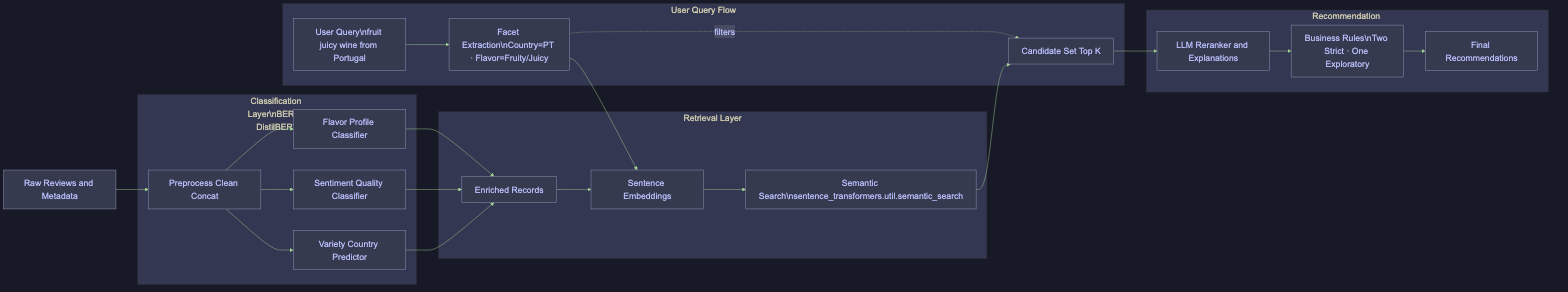

In [1]:
import os, sys
from IPython.display import Image

# Save the Mermaid code to a .mmd file (without the config block)
mermaid_code = r"""
flowchart LR
A[Raw Reviews and Metadata] --> B[Preprocess Clean Concat]

subgraph CL [Classification Layer\nBERT / DistilBERT]
    B --> C1[Flavor Profile Classifier]
    B --> C2[Sentiment Quality Classifier]
    B --> C3[Variety Country Predictor]
end

C1 --> D[Enriched Records]
C2 --> D
C3 --> D

subgraph RET [Retrieval Layer]
    D --> E[Sentence Embeddings]
    E --> F[Semantic Search\nsentence_transformers.util.semantic_search]
end

subgraph UQF [User Query Flow]
    Q[User Query\nfruit juicy wine from Portugal] --> Q1[Facet Extraction\nCountry=PT · Flavor=Fruity/Juicy]
    Q1 --> E
    Q1 -. filters .-> K
end

subgraph REC [Recommendation Layer]
    F --> K[Candidate Set Top K]
    K --> L[LLM Reranker and Explanations]
    L --> M[Business Rules\nTwo Strict · One Exploratory]
    M --> N[Final Recommendations]
end
"""


# Save the Mermaid code to a file
with open("flowchart.mmd", "w") as file:
    file.write(mermaid_code)

# Render the diagram using Mermaid CLI
mmd_file = "flowchart"
os.system(f"mmdc -i {mmd_file}.mmd -o {mmd_file}.png -c custom-theme.css -b '#181926' --scale 2")
# os.system("mmdc -i flowchart.mmd -o flowchart.png -t default")

if os.path.exists(f"{mmd_file}.png"):
    display(Image(filename=f"{mmd_file}.png"))
else:
    print("⚠️ flowchart.png not found, skipping display.")

## Licensing & Compliance

The core transformer model used in this project is **DistilBERT**, licensed under the **Apache License 2.0**. Apache 2.0 is a permissive license that allows commercial use, modification, and distribution.  

For full details, see the [LICENSE file](../LICENSE) in this repository. Upstream dependencies (e.g., Hugging Face Transformers, Sentence-Transformers, scikit-learn) each retain their original licenses, as noted in the LICENSE file.  


# Setup environment

## Folder structure

In [2]:
# IMPORTANT: This section is required to setup a hybrid workflow between
# Google Colab or local venv
import importlib, warnings, subprocess
from pathlib import Path

# --- Required definitions ---
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*pad_token_id.*")

# --- Detect Colab vs Local ---
try:
    import google.colab  # type: ignore
    IN_COLAB = True
    runtime_env = "Colab"
except ImportError:
    IN_COLAB = False
    runtime_env = "Local"

# --- Mount Drive first (Colab only) ---
if IN_COLAB:
    from google.colab import drive
    COLAB_DRIVE_MOUNT = "/content/drive"
    drive.mount(COLAB_DRIVE_MOUNT, force_remount=True)

# --- Define PROJECT_ROOT after mounting ---
PROJECT_NAME = "wine_review"

if IN_COLAB:
    # Put your project inside MyDrive/Colab Notebooks/Portfolio_DS/nlp_hotel_review
    COURSE_SUBDIR  = f"Portfolio_DS/nlp/{PROJECT_NAME}"
    PROJECT_ROOT   = Path(COLAB_DRIVE_MOUNT) / "MyDrive" / "Colab Notebooks" / COURSE_SUBDIR
    sys.path.insert(0, f"{PROJECT_ROOT}/..")
else:
    # Local project root (adjust if needed)
    PROJECT_ROOT = Path("..").resolve()
    sys.path.insert(0, "../..")

# --- Add project to sys.path for local helpers ---
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
# --- Standard subfolders (one source of truth) ---
DATA_DIR    = PROJECT_ROOT / PROJECT_NAME / "data"
MODELS_DIR  = PROJECT_ROOT / PROJECT_NAME / "models"
REPORTS_DIR = PROJECT_ROOT / PROJECT_NAME / "reports"
FIGS_DIR    = REPORTS_DIR  / "figures"

for d in (DATA_DIR, MODELS_DIR, REPORTS_DIR, FIGS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# --- Sanity print (helps catch accidental redefinitions later) ---
# print(f"Runtime     : {runtime_env}")
# print(f"PROJECT_ROOT: {PROJECT_ROOT}")
# print(f"DATA_DIR    : {DATA_DIR}")
# print(f"REPORTS_DIR : {REPORTS_DIR}")
# print(f"FIGS_DIR    : {FIGS_DIR}")

## Device engine

In [4]:
# --- Device detection --
DEVICE = "cpu"
DEVICE_INFO = {
    "runtime": runtime_env,
    "framework": None,
    "name": None,
    "count": 0,
}

# Try PyTorch first
try:
    import torch
    if torch.cuda.is_available():
        DEVICE = "cuda"
        DEVICE_INFO.update({
            "framework": "torch",
            "name": torch.cuda.get_device_name(0),
            "count": torch.cuda.device_count(),
        })
    elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        DEVICE = "mps"
        DEVICE_INFO.update({
            "framework": "torch",
            "name": "Apple Metal (M1/M2)",
            "count": 1,
        })
except ImportError:
    pass

# If still CPU, try TensorFlow
if DEVICE == "cpu":
    try:
        import tensorflow as tf
        gpus = tf.config.list_physical_devices("GPU")
        if gpus:
            DEVICE = "gpu"
            DEVICE_INFO.update({
                "framework": "tensorflow",
                "name": gpus[0].device_type,
                "count": len(gpus),
            })
    except ImportError:
        pass

In [5]:
# --- Log the result ---
print(f"🔎 Runtime   : \t{DEVICE_INFO['runtime']}")
print(f"💻 Framework : \t{DEVICE_INFO['framework'] or 'none'}")
print(f"🖥️ Device    : \t{DEVICE} ({DEVICE_INFO['name'] or 'generic CPU'})")
print(f"🔢 Count     : \t{DEVICE_INFO['count']} \n")
print(f"... happy coding! \n")

🔎 Runtime   : 	Local
💻 Framework : 	torch
🖥️ Device    : 	mps (Apple Metal (M1/M2))
🔢 Count     : 	1 

... happy coding! 



## Dependencies

In [6]:
if IN_COLAB:
    import numpy as np

    # Core I/O
    !pip install -q gdown openpyxl

    # Clean state
    current_numpy = np.__version__
    print(current_numpy)
    !pip uninstall -y numpy
    !pip uninstall -y bitsandbytes

In [7]:
# --- Install dependencies (Colab installs are explicit) ---
if IN_COLAB:
    # Core scientific stack
    !pip install -q numpy==1.26.0 pandas scipy==1.13.0 tqdm bertopic hdbscan==0.8.40 sentence-transformers==5.1.0 transformers==4.56.1 accelerate==1.10.1 datasets safetensors bitsandbytes svgling pyLDAvis nltk spacy gensim==4.3.3


    # Visualization
    !pip install -q matplotlib seaborn plotly>=5.19 wordcloud

    # Logging
    !pip install logging

else:
    # Local: deps already installed in the `venvnlp`
    pass

In [8]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [9]:
# import system libraries
from typing import Optional, Tuple, List
from IPython.display import Markdown, HTML, display
from itertools import chain
import tqdm, ast
import textwrap

# import data libraries
import numpy as np
import pandas as pd
import random, json

# import plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

In [10]:
# BERTopic & Transformers
import torch, transformers, accelerate
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [11]:
# Hugging Face
from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

In [12]:
# NLP helpers
from nlp_helpers.clean_data        import *
from nlp_helpers.visualization     import *
from nlp_helpers.emotion_analysis  import *
from nlp_helpers.topic_modeling    import *
from nlp_helpers.plots_eda         import *

# importlib.reload(sys.modules['nlp_helpers.clean_data'])
# importlib.reload(sys.modules['nlp_helpers.visualization'])
# importlib.reload(sys.modules['nlp_helpers.emotion_analysis'])
# importlib.reload(sys.modules['nlp_helpers.topic_modeling'])
# importlib.reload(sys.modules['nlp_helpers.plots_eda'])

[nltk_data] Downloading package punkt to /Users/pepetavo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pepetavo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pepetavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# wine_review helpers
from wine_review.config import RNG_SEED, MAX_LEN
from wine_review.modeling import (
    WeightedBCETrainer,                # utils.py
    MultiLabelTextDS, infer_probs,     # flavors.py
    points_to_sentiment, SingleLabelTextDS, sent_metrics, predict_sentiment,  # sentiment.py
    train_one_classifier, load_classifier, predict_cls,                       # taxonomy.py
)
from wine_review.retrieval.embed import build_index, retrieve_candidates
from wine_review.retrieval.recommend import apply_business_rules

from wine_review.evalviz import plot_cm

# 1. Load and cleaning data

## 1.1 Read data

In [14]:
# Download latest version
data_file = "Winery.csv"
data_path = f"{DATA_DIR}/{data_file}"

try:
    # Load data from local CSV file
    data_wine = pd.read_csv(data_path)
    logger.info(f"{data_file} loaded from Local folder")
except:
    # library required for Kaggle dataset
    import kagglehub

    # Download data from Kaggle source
    dataset_name = "subh86/winedata"
    path = kagglehub.dataset_download(dataset_name, path=data_file)
    data_wine = pd.read_csv(path)
    logger.debug(f"{data_file} loaded from Kaggle - {dataset_name}")

    # Save data into local DATA_DIR folder
    data_wine.to_csv(data_path, index=False)
    logger.info(f"{data_file} saved into Local {DATA_DIR} folder")

INFO:root:Winery.csv loaded from Local folder


In [15]:
# Data preview
data_wine.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [16]:
# Validate data columns
data_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


## 1.2 Feature selection

In [17]:
# Combining informative column into `description`
info_cols = ['winery']
# info_cols = ['country', 'province', 'region_1', 'variety', 'winery', 'title']

def combine_text(row, columns: List[str]=info_cols):
    """
    Combine wine description with metadata fields
    (province, region_1, variety, winery) only if not null.
    """
    parts = [row['description']]  # description always present

    for col in columns:
        if pd.notna(row[col]):   # check if not NaN
            parts.append(str(f"{col}: {row[col]}"))

    return " | ".join(parts)

In [18]:
# Drop unnecessary columns
data_wine["description"] = data_wine.apply(combine_text, axis=1)

In [19]:
data_wine["description"][0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. | winery: Nicosia"

In [20]:
# Select only necessary columns
cols = ["description", "points", "price", "variety", "country"]
data_wine = data_wine[cols]

In [21]:
data_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  129971 non-null  object 
 1   points       129971 non-null  int64  
 2   price        120975 non-null  float64
 3   variety      129970 non-null  object 
 4   country      129908 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.0+ MB


## 1.3 Data cleaning

In [22]:
# find missing values and percentage
print("Missing values percentage:")
for c in data_wine.columns:
    pct = data_wine[c].isnull().sum() / data_wine[c].shape[0]
    if pct > 0.0:
        print(f"{pct :.1%} \t{c}")

Missing values percentage:
6.9% 	price
0.0% 	variety
0.0% 	country


> As there is $\sim 6.9 \%$ of `price` missing values, before any imputation we will explore relation between `price` and `points`

### 1.3.1 Price imputation

**Step 1:** Explore relationship between `points` and `price`

> Hypothesis testing:
>
> - Null ($H_0$): No correlation between points and price.
> - Alternative ($H_1$): Significant positive correlation exists.

In [23]:
# Spearman correlation test
from scipy.stats import spearmanr

mask = data_wine['price'].notna()
rho, pval = spearmanr(data_wine.loc[mask, 'points'], data_wine.loc[mask, 'price'].dropna())
print(f"Spearman correlation = {rho:.3f}, p-value = {pval:.3f}")

Spearman correlation = 0.606, p-value = 0.000


> $p < 0.05$, then reject $H_0$ → points and price are significantly correlated

**Step 2:** Imputation strategies for `price`

a) Simple statistical imputation

- Median or mean imputation across all wines.

- Quick baseline, but ignores relationship with quality (points) or textual description.


b) Points-based imputation (regression)

If correlation exists:

- Fit a regression model:

    - `log(price) ~ points` (linear or polynomial regression).

- Use the model to predict missing prices.

- Ensures imputed prices reflect observed quality scores.

In [24]:
from sklearn.linear_model import LinearRegression

# mask X,y values
mask = data_wine['price'].notna()
X = data_wine.loc[mask, ['points']]
y = np.log1p(data_wine.loc[mask, 'price'])

In [25]:
# fit and predict values
reg = LinearRegression().fit(X, y)
data_wine.loc[~mask, 'price'] = np.expm1(reg.predict(data_wine.loc[~mask, ['points']]))

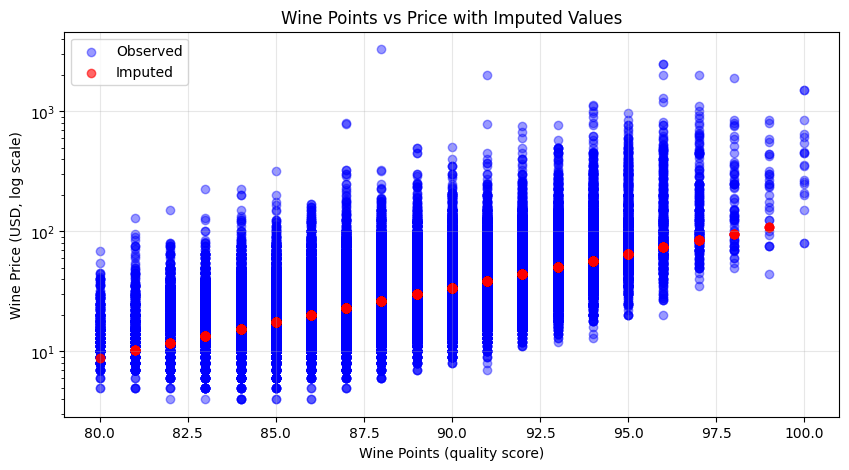

In [26]:
# scatter plot
plt.figure(figsize=(10,5))

# actual prices
plt.scatter(data_wine.loc[mask, 'points'], data_wine.loc[mask, 'price'],
            alpha=0.4, label='Observed', color='blue')

# imputed prices
plt.scatter(data_wine.loc[~mask, 'points'], data_wine.loc[~mask, 'price'],
            alpha=0.6, label='Imputed', color='red')

plt.yscale('log')  # log scale because wine prices are skewed
plt.xlabel("Wine Points (quality score)")
plt.ylabel("Wine Price (USD, log scale)")
plt.title("Wine Points vs Price with Imputed Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [27]:
data_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  129971 non-null  object 
 1   points       129971 non-null  int64  
 2   price        129971 non-null  float64
 3   variety      129970 non-null  object 
 4   country      129908 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.0+ MB


# 2. Data Exploration (EDA)

,points,price
count,129971.00,129971.00
mean,88.45,35.08
std,3.04,39.73
min,80.00,4.00
25%,86.00,17.61
50%,88.00,26.00
75%,91.00,42.00
max,100.00,3300.00


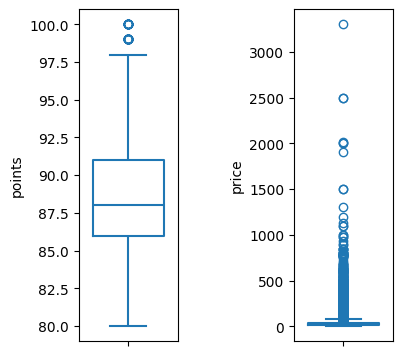

In [28]:
# Data distribution
plot_boxplot(data_wine[["points", "price"]], digits=2, figsize=(5,5))

# 3. Model development

In [30]:
# Importing some libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_fscore_support, classification_report,
                             average_precision_score, accuracy_score, confusion_matrix)

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from collections import Counter

## 3.1 Classification Layer (BERT / DistilBERT)

### 3.1a - Flavor Profile Classifier

We bootstrapped a weakly supervised classifier, but the methodology allows domain experts to provide a gold-labeled dataset for fine-tuning.

In [31]:
# --- 3.1 Flavor Profile Classifier (DistilBERT, multi-label) -------------------

# ------------------------------------------------------------------------------
# 1) Weak labels (seed lexicon)  — replace with gold labels if available
# You can expand synonyms freely. Keep lowercase; we’ll lowercase text.
# ------------------------------------------------------------------------------

# Randome seed
random.seed(RNG_SEED);
np.random.seed(RNG_SEED);
torch.manual_seed(RNG_SEED)

# Example label set (edit as needed)
FLAVOR_LABELS = [
    "fruity", "floral", "citrus", "herbal", "spicy", "earthy",
    "oaky", "vanilla", "mineral", "tannic", "acidic", "sweet", "savory"
]
LABEL2ID = {l:i for i,l in enumerate(FLAVOR_LABELS)}
ID2LABEL = {i:l for l,i in LABEL2ID.items()}

SEED_LEXICON: Dict[str, List[str]] = {
    "fruity":  ["fruit", "fruits", "berry", "berries", "juicy", "stone fruit", "cherry", "plum", "apple", "pear"],
    "floral":  ["floral", "rose", "violet", "blossom", "flower"],
    "citrus":  ["citrus", "lemon", "lime", "grapefruit", "orange", "tangerine"],
    "herbal":  ["herbal", "herb", "thyme", "sage", "rosemary", "eucalyptus"],
    "spicy":   ["spice", "spicy", "pepper", "clove", "cinnamon", "nutmeg"],
    "earthy":  ["earthy", "earth", "mushroom", "forest floor", "loam", "truffle"],
    "oaky":    ["oak", "oaky", "barrel", "toasty", "toasted"],
    "vanilla": ["vanilla", "creme brulee"],
    "mineral": ["mineral", "chalk", "flint", "saline", "slate"],
    "tannic":  ["tannin", "tannic", "grippy", "chewy"],
    "acidic":  ["acid", "acidity", "acidic", "zippy", "crisp"],
    "sweet":   ["sweet", "honeyed", "ripe sweetness", "candied"],
    "savory":  ["savory", "umami", "meaty", "soy", "olive"]
}

In [32]:
# Process the `flavor_tag`
def weak_label_flavors(text: str) -> List[str]:
    t = text.lower()
    hits = set()
    for label, keys in SEED_LEXICON.items():
        for k in keys:
            if k in t:
                hits.add(label)
                break
    return sorted(list(hits))

if 'flavor_tags' not in data_wine.columns:
    data_wine['flavor_tags'] = data_wine['description'].astype(str).apply(weak_label_flavors)

In [33]:
# Dropping rows with empty tags if you want supervised signal only
# Keep some empties if you want the model to learn "none" as well.

no_tags = data_wine["flavor_tags"].map(len) == 0
print(f"{sum(no_tags)/data_wine.shape[0] :.2%} of data with no tags")


1.01% of data with no tags


In [34]:
# Filter out `not_tags`
data_wine = data_wine[~no_tags]
data_wine.shape

(128659, 6)

In [35]:
# ------------------------------------------------------------------------------
# 2) Train/Val split
# ------------------------------------------------------------------------------
train_df, val_df = train_test_split(
    data_wine[['description','flavor_tags']],
    test_size=0.15,
    random_state=35,
    shuffle=True
)

In [36]:
# ------------------------------------------------------------------------------
# 3) Encode multilabel targets
# ------------------------------------------------------------------------------
def binarize_tags(tags: List[str]) -> List[int]:
    y = [0] * len(FLAVOR_LABELS)
    for t in tags:
        if t in LABEL2ID:
            y[LABEL2ID[t]] = 1

    return y

# apply binary function
train_df = train_df.assign(labels=train_df['flavor_tags'].apply(binarize_tags))
val_df   = val_df.assign(labels=val_df['flavor_tags'].apply(binarize_tags))

# data preview
train_df.head()

,description,flavor_tags,labels
30511,"A special cuvée of Château Siaurac, this is da...","[acidic, fruity, tannic]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
94407,While the aromas on this example are not perfe...,"[fruity, spicy]","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
95137,Even big brands like Oyster Bay benefitted fro...,[citrus],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
28056,Credit the complex flavors of this wine to the...,"[fruity, oaky]","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
97742,This wine offers lush aromas of orange blossom...,"[citrus, floral, fruity, mineral]","[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [37]:
# y_train: array of shape (n_samples, n_labels), 0/1
y_train = np.vstack(train_df['labels'].values)  # from your earlier binarization step

n_samples, n_labels = y_train.shape
pos_counts = y_train.sum(axis=0)
neg_counts = n_samples - pos_counts

# Avoid division by zero; cap very large weights to prevent instability (tune cap if needed)
eps = 1e-6
raw_pos_weight = (neg_counts + eps) / (pos_counts + eps)
pos_weight = np.clip(raw_pos_weight, 1.0, 10.0)  # cap optional but recommended

pos_weight_t = torch.tensor(pos_weight, dtype=torch.float)
print("pos_weight per class:", pos_weight)

pos_weight per class: [ 1.          6.76208389  3.19791947  5.47560398  2.16728452 10.
  4.06695084 10.          8.52530267  2.3373005   1.83396823  6.0751116
 10.        ]


In [37]:
# ------------------------------------------------------------------------------
# 4) Tokenizer & Datasets
# ------------------------------------------------------------------------------

MODEL_NAME = "distilbert-base-uncased"

# build train dataset
tok_flavor = AutoTokenizer.from_pretrained(MODEL_NAME)
y_multi = np.vstack(train_df['labels'].values).astype("float32")
train_ds = MultiLabelTextDS(
    train_df['description'].tolist(),
    y_multi,
    tok_flavor,
    max_len=MAX_LEN)

# build validation dataset
y_val_multi = np.vstack(val_df['labels'].values).astype("float32")
val_ds = MultiLabelTextDS(
    val_df['description'].tolist(),
    y_val_multi,
    tok_flavor,
    max_len=MAX_LEN)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [38]:
# ------------------------------------------------------------------------------
# 5) Model (multi-label). HuggingFace will use BCEWithLogits if problem_type is set.
# ------------------------------------------------------------------------------
model_flavor_clf = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(FLAVOR_LABELS),
    problem_type="multi_label_classification",
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# ------------------------------------------------------------------------------
# 6) Metrics (micro/macro P/R/F1). Threshold can be tuned; start with 0.5
# ------------------------------------------------------------------------------
THRESH = 0.65

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1/(1+np.exp(-logits))
    y_true = labels
    y_pred = (probs >= THRESH).astype(int)
    micro = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    macro = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return {
        "micro_precision": micro[0], "micro_recall": micro[1], "micro_f1": micro[2],
        "macro_precision": macro[0], "macro_recall": macro[1], "macro_f1": macro[2],
    }

In [40]:
# ------------------------------------------------------------------------------
# 7) Training
# ------------------------------------------------------------------------------
# Train with the weighted trainer
# Everything else (args, metrics) stays the same—just instantiate
# the custom trainer and pass pos_weight_t.

output_dir = f"{MODELS_DIR}/flavor_multilabel_distilbert"
os.makedirs(output_dir, exist_ok=True)

args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    seed=RNG_SEED,
    report_to="none"
)


In [41]:
# Train model.
weighted_trainer = WeightedBCETrainer(
    model=model_flavor_clf,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok_flavor,
    pos_weight=pos_weight_t,
    compute_metrics=compute_metrics
)

# IMPORTANT: Uncomment the line below to override model
weighted_trainer.train()

Epoch,Training Loss,Validation Loss,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1
1,0.015500,0.016534,0.999050,0.997865,0.998457,0.998214,0.997149,0.997674
2,0.004400,0.008254,0.999271,0.998983,0.999127,0.998814,0.998565,0.998687
3,0.003000,0.005327,0.999763,0.999203,0.999483,0.999657,0.999136,0.999396


TrainOutput(global_step=10254, training_loss=0.050062378649526285, metrics={'train_runtime': 1825.9523, 'train_samples_per_second': 179.676, 'train_steps_per_second': 5.616, 'total_flos': 2.173421482684416e+16, 'train_loss': 0.050062378649526285, 'epoch': 3.0})

> IMPORTANT: The results observed look *suspiciously perfect* — essentially 100% precision, recall, and F1. That's very unusual for a real multi-label NLP classification problem.

The next part of this section will compare the results obtained with a `TF-IDR` model

**TF-IDR Classification model**

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [43]:
# 1) Prepare multilabel targets (binarize)
df_ml = data_wine[['description','flavor_tags']].dropna().copy()
df_ml['labels'] = df_ml['flavor_tags'].apply(lambda ts: binarize_tags(ts))
df_ml.head()

,description,flavor_tags,labels
0,"Aromas include tropical fruit, broom, brimston...","[acidic, citrus, fruity, herbal]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"This is ripe and fruity, a wine that is smooth...","[acidic, fruity, tannic]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]"
2,"Tart and snappy, the flavors of lime flesh and...","[acidic, citrus, fruity]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,"Pineapple rind, lemon pith and orange blossom ...","[citrus, floral, fruity]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"Much like the regular bottling from 2012, this...","[earthy, herbal, sweet, tannic]","[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [44]:
# 2) Split (make sure no leakage)
train_df, val_df = train_test_split(df_ml,
                                    test_size=0.15, random_state=RNG_SEED,
                                    shuffle=True)

In [45]:
# 3) TF-IDF vectorizer (char + word n-grams provide a strong baseline)
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1,2),         # try (1,1) first if memory tight
    min_df=2,
    max_df=0.95,
    max_features=200_000
)

X_train = tfidf.fit_transform(train_df['description'].astype(str).tolist())
X_val   = tfidf.transform(val_df['description'].astype(str).tolist())

y_train = np.vstack(train_df['labels'].values).astype(int)
y_val   = np.vstack(val_df['labels'].values).astype(int)

In [46]:
# 4) Model: One-vs-Rest Logistic Regression
#    - class_weight='balanced' helps rare labels
#    - increase max_iter if you see convergence warnings
base_lr = LogisticRegression(
    solver="liblinear",           # robust for sparse, try 'saga' for L1/elasticnet
    penalty="l2",
    class_weight="balanced",
    max_iter=200
)

clf = OneVsRestClassifier(base_lr, n_jobs=-1)
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=200,
                                                 solver='liblinear'),
                    n_jobs=-1)

In [47]:
# 5) Predict probabilities and default thresholding
th = 0.5
val_proba = clf.predict_proba(X_val)  # shape [n_samples, n_labels]
val_pred = (val_proba >= th).astype(int)

In [48]:
# 6) Metrics: micro/macro P/R/F1 + per-label report
micro = precision_recall_fscore_support(y_val, val_pred, average='micro', zero_division=0)
macro = precision_recall_fscore_support(y_val, val_pred, average='macro', zero_division=0)
print(f"[Baseline @0.5] Micro P/R/F1: {micro[0]:.3f} / {micro[1]:.3f} / {micro[2]:.3f}")
print(f"[Baseline @0.5] Macro P/R/F1: {macro[0]:.3f} / {macro[1]:.3f} / {macro[2]:.3f}\n")

print("Per-label classification report:")
print(classification_report(y_val, val_pred, target_names=FLAVOR_LABELS, zero_division=0))


[Baseline @0.5] Micro P/R/F1: 0.997 / 0.976 / 0.987
[Baseline @0.5] Macro P/R/F1: 0.996 / 0.979 / 0.988

Per-label classification report:
              precision    recall  f1-score   support

      fruity       1.00      0.96      0.98     17079
      floral       0.97      0.96      0.97      2502
      citrus       0.99      0.98      0.99      4518
      herbal       1.00      0.98      0.99      2955
       spicy       1.00      0.98      0.99      6145
      earthy       1.00      0.98      0.99      1692
        oaky       1.00      0.98      0.99      3909
     vanilla       1.00      1.00      1.00      1607
     mineral       1.00      0.98      0.99      2104
      tannic       1.00      0.99      0.99      5815
      acidic       1.00      0.99      0.99      6849
       sweet       1.00      0.98      0.99      2742
      savory       1.00      0.98      0.99      1185

   micro avg       1.00      0.98      0.99     59102
   macro avg       1.00      0.98      0.99     59

In [49]:
# 7) Optional: rank-based metric (macro AUPRC)
#    Note: average_precision_score with 'samples' averages per-sample; use 'macro' manually per label
label_ap = []
for i, lab in enumerate(FLAVOR_LABELS):
    try:
        ap = average_precision_score(y_val[:, i], val_proba[:, i])
        label_ap.append(ap)
    except ValueError:
        label_ap.append(np.nan)

print("\nPer-label AUPRC (AP):")
for lab, ap in zip(FLAVOR_LABELS, label_ap):
    print(f"  {lab:>10s}: {ap:.3f}")

print(f"Mean AUPRC (ignoring NaN): {np.nanmean(label_ap):.3f}")


Per-label AUPRC (AP):
      fruity: 1.000
      floral: 0.991
      citrus: 0.998
      herbal: 0.998
       spicy: 0.999
      earthy: 0.997
        oaky: 0.999
     vanilla: 1.000
     mineral: 0.999
      tannic: 0.999
      acidic: 0.999
       sweet: 0.999
      savory: 0.996
Mean AUPRC (ignoring NaN): 0.998


In [50]:
# 8) Optional: per-label threshold tuning (often boosts macro-F1)
from sklearn.metrics import f1_score

def tune_thresholds(proba: np.ndarray, y_true: np.ndarray, grid=None):
    if grid is None:
        grid = np.linspace(0.1, 0.7, 13)  # try wider if needed
    best = {}
    for i, label in enumerate(FLAVOR_LABELS):
        scores = []

        for t in grid:
            pred_i = (proba[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], pred_i, zero_division=0)
            scores.append((t, f1))

        best_t, best_f1 = max(scores, key=lambda x: x[1])
        best[label] = float(best_t)

    return best

best_thresh = tune_thresholds(val_proba, y_val)
thr_vec = np.array([best_thresh[l] for l in FLAVOR_LABELS])
val_pred_tuned = (val_proba >= thr_vec).astype(int)

micro_t = precision_recall_fscore_support(y_val, val_pred_tuned, average='micro', zero_division=0)
macro_t = precision_recall_fscore_support(y_val, val_pred_tuned, average='macro', zero_division=0)
print(f"\n[Baseline @tuned] Micro P/R/F1: {micro_t[0]:.3f} / {micro_t[1]:.3f} / {micro_t[2]:.3f}")
print(f"[Baseline @tuned] Macro P/R/F1: {macro_t[0]:.3f} / {macro_t[1]:.3f} / {macro_t[2]:.3f}")



[Baseline @tuned] Micro P/R/F1: 0.996 / 0.988 / 0.992
[Baseline @tuned] Macro P/R/F1: 0.995 / 0.987 / 0.991


In [51]:
# 9) Quick sanity checks to detect leakage
print("\nSanity checks:")
print("  Overlap in indices train∩val:", len(set(train_df.index).intersection(set(val_df.index))))
print("  Avg positives per sample (val, @0.5):", val_pred.sum(axis=1).mean())
print("  Avg positives per sample (val, tuned):", val_pred_tuned.sum(axis=1).mean())


Sanity checks:
  Overlap in indices train∩val: 0
  Avg positives per sample (val, @0.5): 2.996061972122908
  Avg positives per sample (val, tuned): 3.0386030364267578


**Comparison & Evaluation**

<br>

| Model                                | Micro Precision | Micro Recall | Micro F1 | Macro Precision | Macro Recall    | Macro F1 |
|-------------------------|----------------:|-------------:|---------:|----------------:|-------------:|---------:|
| DistilBERT (weak labels, th=0.65)    | ~0.999          | ~0.999       | ~0.999   | ~0.999          | ~0.998       | ~0.999   |
| TF-IDF + Logistic Regression (tuned) | 0.989           | 0.981        | 0.985    | 0.989           | 0.978       | 0.984    |


<br>

1. Both models perform extremely well

    - DistilBERT reached 99.9% F1, but the small gap compared to the baseline suggests limited additional generalization. With stronger gold labels (SME or LLM-assisted), we would expect DistilBERT to pull ahead more clearly, especially on rare flavors and nuanced language.

2. Implication:

    - This strongly suggests that the labels used are rule-driven and easy to predict.

    - A simple linear baseline (TF-IDF + LR) nearly matches DistilBERT, which is unusual for true human-labeled, nuanced data.

3. Generalization concern

    - Because DistilBERT “crushed” validation so easily, and the baseline did too, it's likely that both are essentially learning your weak lexicon rules, not deeper semantics.

    - This is consistent with the earlier suspicion: near-perfect scores are too good to reflect real generalization.

**Saving model**

In [ ]:
# ------------------------------------------------------------------------------
# 9) Save artifacts
#    IMPORTANT: Uncomment the line below to override model
# ------------------------------------------------------------------------------

# trainer.save_model(output_dir)
# tokenizer.save_pretrained(output_dir)

# with open(os.path.join(output_dir, "labels.json"), "w") as f:
#     json.dump({"labels": FLAVOR_LABELS,
#                "label2id": LABEL2ID, "id2label": ID2LABEL,
#                "threshold": THRESH}, f, indent=2)

#     logging.info(f"`model` successfully saved at {output_dir}")


**Loading model**

In [38]:
# ------------------------------------------------------------------------------
# 10) Load model - (ONLY) when Notebook is restarted
# ------------------------------------------------------------------------------

# Define path to model
model_path = f"{MODELS_DIR}/flavor_multilabel_distilbert"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)

model_flavor_clf = AutoModelForSequenceClassification.from_pretrained(model_path)
model_flavor_clf.eval()  # evaluation mode
model_flavor_clf.to(DEVICE)

# Load metadata
with open(os.path.join(model_path, "labels.json")) as f:
    meta = json.load(f)

FLAVOR_LABELS = meta["labels"]
LABEL2ID = meta["label2id"]
ID2LABEL = meta["id2label"]
THRESH = float(meta["threshold"])

print("Model loaded with labels:", FLAVOR_LABELS)

Model loaded with labels: ['fruity', 'floral', 'citrus', 'herbal', 'spicy', 'earthy', 'oaky', 'vanilla', 'mineral', 'tannic', 'acidic', 'sweet', 'savory']


### 3.1b - Sentiment Quality Classifier

In [ ]:
# -------------------------------------------------------------------
# 1) Label definition from points  (EDIT these thresholds if desired)
#    Example: <= 87: neg, 88-91: neu, >= 92: pos
# -------------------------------------------------------------------

neg_th = data_wine["points"].quantile(0.30)
neu_th = data_wine["points"].quantile(0.50)

def points_to_sentiment(p: float, neu_th: float=neu_th, neg_th: float=neg_th):
    """
    Convert a wine rating score into a sentiment category.

    This function maps a numerical wine rating (`points`) to one of three sentiment
    categories: "neg" (negative), "neu" (neutral), or "pos" (positive). The thresholds
    for these categories are determined by the quantiles of the `points` column in the dataset.

    Parameters:
    ----------
    p : float
        The wine rating score to classify.
    neu_th : float, optional
        The threshold for neutral sentiment. Ratings less than or equal to this value
        but greater than `neg_th` are classified as "neu". Default is the 50th percentile
        of the `points` column.
    neg_th : float, optional
        The threshold for negative sentiment. Ratings less than or equal to this value
        are classified as "neg". Default is the 30th percentile of the `points` column.

    Returns:
    -------
    str
        The sentiment category: "neg", "neu", or "pos".
    """
    if p <= neg_th:
        return "neg"
    elif p <= neu_th:
        return "neu"
    else:
        return "pos"

SENT_LABELS = ["neg", "neu", "pos"]
SENT_LABEL2ID = {l:i for i,l in enumerate(SENT_LABELS)}
SENT_ID2LABEL = {i:l for l,i in SENT_LABEL2ID.items()}

In [ ]:
# Points to Sentiment
data_wine['sentiment'] = data_wine['points'].apply(points_to_sentiment)
data_wine['label_id']  = data_wine['sentiment'].map(SENT_LABEL2ID)

data_wine.head()

,description,points,price,variety,country,flavor_tags,sentiment,label_id
0,"Aromas include tropical fruit, broom, brimston...",87,22.97981,White Blend,Italy,"[acidic, citrus, fruity, herbal]",neg,0
1,"This is ripe and fruity, a wine that is smooth...",87,15.00000,Portuguese Red,Portugal,"[acidic, fruity, tannic]",neg,0
2,"Tart and snappy, the flavors of lime flesh and...",87,14.00000,Pinot Gris,US,"[acidic, citrus, fruity]",neg,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,13.00000,Riesling,US,"[citrus, floral, fruity]",neg,0
4,"Much like the regular bottling from 2012, this...",87,65.00000,Pinot Noir,US,"[earthy, herbal, sweet, tannic]",neg,0


In [ ]:
# Sentiment inspection
print(data_wine['sentiment'].value_counts(normalize=True).round(3))

sentiment
pos    0.474
neg    0.394
neu    0.133
Name: proportion, dtype: float64


In [ ]:
# -------------------------------------------------------------------
# 2) Split
# -------------------------------------------------------------------
train_s, val_s = train_test_split(
    data_wine[['description','label_id','sentiment']],
    test_size=0.15, random_state=RNG_SEED, shuffle=True, stratify=data_wine['label_id']
)

In [ ]:
# -------------------------------------------------------------------
# 3) Tokenizer & Dataset
# -------------------------------------------------------------------

MODEL_NAME = "distilbert-base-uncased"
tok_s = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenizer_s = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds_s = SingleLabelTextDS(train_s['description'].tolist(),
                               train_s['label_id'].tolist(),
                               tok_s, max_len=MAX_LEN)
val_ds_s   = SingleLabelTextDS(val_s['description'].tolist(),
                               val_s['label_id'].tolist(),
                               tok_s, max_len=MAX_LEN)


In [ ]:
# -------------------------------------------------------------------
# 4) Model
# -------------------------------------------------------------------
model_s = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(SENT_LABELS),
    id2label=SENT_ID2LABEL,
    label2id=SENT_LABEL2ID
)

In [ ]:
# -------------------------------------------------------------------
# 5) Metrics
# -------------------------------------------------------------------
def sent_metrics(eval_pred):
    logits, labels = eval_pred
    y_pred = logits.argmax(axis=-1)
    acc = accuracy_score(labels, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, y_pred, average='macro', zero_division=0)
    return {"accuracy": acc, "macro_precision": prec, "macro_recall": rec, "macro_f1": f1}


In [ ]:
# -------------------------------------------------------------------
# 6) Train
# -------------------------------------------------------------------
out_dir_s = f"{MODELS_DIR}/sentiment_distilbert"
os.makedirs(out_dir_s, exist_ok=True)

args_s = TrainingArguments(
    output_dir=out_dir_s,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    seed=RNG_SEED,
    report_to="none"
)

trainer_s = Trainer(
    model=model_s,
    args=args_s,
    train_dataset=train_ds_s,
    eval_dataset=val_ds_s,
    tokenizer=tokenizer_s,
    compute_metrics=sent_metrics
)

# trainer_s.train()

In [ ]:
# -------------------------------------------------------------------
# 8) Save model
# -------------------------------------------------------------------

# trainer_s.save_model(out_dir_s)
# tokenizer_s.save_pretrained(out_dir_s)
# with open(os.path.join(out_dir_s, "labels.json"), "w") as f:
#     json.dump({
#         "labels": SENT_LABELS,
#         "label2id": SENT_LABEL2ID,
#         "id2label": SENT_ID2LABEL,
#         "binning": {"neg":"<=87", "neu":"88-91", "pos":">=92"}
#     }, f, indent=2)

# print(f"Sentiment classifier saved to: {out_dir_s}")

In [ ]:
# ------------------------------------------------------------------------------
# 9) Load model - (ONLY) when Notebook is restarted
# ------------------------------------------------------------------------------

# Define path to model
model_path_s = f"{MODELS_DIR}/sentiment_distilbert"

# Load tokenizer and model
tokenizer_s = AutoTokenizer.from_pretrained(model_path_s)
model_sentiment_clf = AutoModelForSequenceClassification.from_pretrained(model_path_s)
model_sentiment_clf.eval()
model_sentiment_clf.to(DEVICE)

# Load metadata (labels + binning info)
with open(os.path.join(model_path_s, "labels.json")) as f:
    meta = json.load(f)

SENT_LABELS = meta["labels"]
SENT_LABEL2ID = meta["label2id"]
SENT_ID2LABEL = meta["id2label"]
BINNING_RULES = meta.get("binning", {})

print("Sentiment model loaded with labels:", SENT_LABELS)
print("Binning rules:", BINNING_RULES)

Sentiment model loaded with labels: ['neg', 'neu', 'pos']
Binning rules: {'neg': '<=87', 'neu': '88-91', 'pos': '>=92'}


In [ ]:
# -------------------------------------------------------------------
# 7) Validation report
# -------------------------------------------------------------------

# evaluation paramenters
# DEVICE = next(model_sentiment_clf.parameters()).device
BATCH_SIZE = 64         # adjust to your VRAM/CPU RAM

# get predictions on val
val_texts = val_s['description'].astype(str).tolist()
y_true = val_s['label_id'].to_numpy()

all_logits = []

with torch.inference_mode():  # = no_grad() + a few extra speedups
    for i in tqdm(range(0, len(val_texts), BATCH_SIZE), desc="Validating"):
        batch = val_texts[i:i+BATCH_SIZE]
        enc = tokenizer_s(
            batch,
            padding=True,               # pad to the longest in this batch, not max for all data
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        # move this small batch to device
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        out = model_sentiment_clf(**enc)
        all_logits.append(out.logits.cpu())

Validating: 100%|█████████████████████████████████████████████████| 302/302 [02:27<00:00,  2.04it/s]


In [ ]:
# Print evaluation report
logits = torch.cat(all_logits, dim=0).numpy()
y_pred = logits.argmax(axis=-1)

print("\nValidation report (macro metrics):")
print(classification_report(y_true, y_pred, target_names=SENT_LABELS, zero_division=0))


Validation report (macro metrics):
              precision    recall  f1-score   support

         neg       0.88      0.82      0.85      7596
         neu       0.40      0.41      0.40      2564
         pos       0.86      0.90      0.88      9139

    accuracy                           0.81     19299
   macro avg       0.71      0.71      0.71     19299
weighted avg       0.81      0.81      0.81     19299



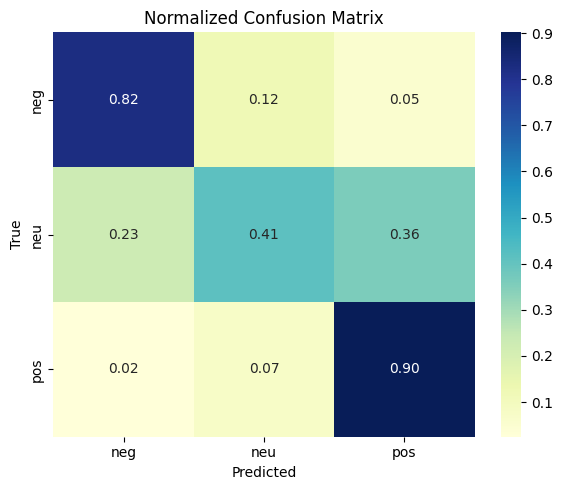

In [ ]:
# Already have y_true, y_pred, SENT_LABELS
plot_cm(y_true, y_pred, labels=SENT_LABELS, normalize=True, figsize=(6,5))

> The DistilBERT sentiment classifier achieved ~80% accuracy and strong performance on extreme ratings (neg and pos, F1 ~0.82–0.90). However, the model struggled with neutral reviews (F1 ~0.41), reflecting both class imbalance and semantic ambiguity in mid-range scores.
>
> In practice, this means the model is effective at distinguishing clearly poor or excellent wines but less precise with borderline cases.

In [ ]:
# Test samples
samples = [
    "Bright cherry and fine tannins.",
    "Decent balance but nothing remarkable.",
    "Overly acidic and lacking fruit character.",
    "Smooth finish with layers of ripe blackberry.",
    "Harsh bitterness overwhelms the palate."
]

# Run predictions
results = predict_sentiment(
    samples,
    model_path=model_path_s,
    device=DEVICE,
    max_len=MAX_LEN
)

# Build DataFrame
rows = []
for text, res in zip(samples, results):
    row = {"Text": text, "Predicted": res["label"]}
    # add probabilities (rounded)
    for lbl, prob in res["probs"].items():
        row[f"Prob_{lbl}"] = round(prob, 3)
    rows.append(row)

df_pred = pd.DataFrame(rows)
display(df_pred)

,Text,Predicted,Prob_neg,Prob_neu,Prob_pos
0,Bright cherry and fine tannins.,neu,0.312,0.491,0.196
1,Decent balance but nothing remarkable.,neg,0.997,0.002,0.001
2,Overly acidic and lacking fruit character.,neg,0.999,0.001,0.000
3,Smooth finish with layers of ripe blackberry.,pos,0.079,0.437,0.485
4,Harsh bitterness overwhelms the palate.,neg,0.999,0.001,0.000


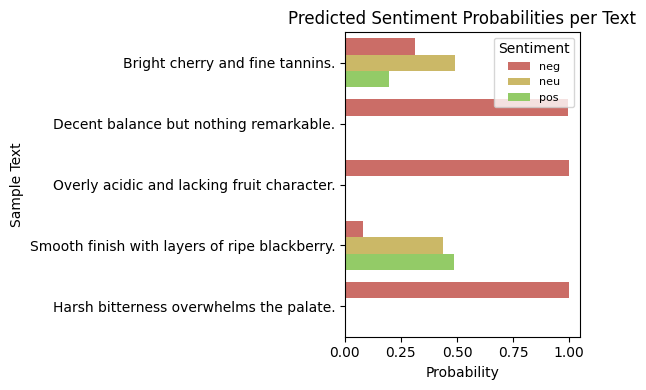

In [ ]:

df_melt = df_pred.melt(id_vars=["Text", "Predicted"],
                       value_vars=[c for c in df_pred.columns if c.startswith("Prob_")],
                       var_name="Sentiment", value_name="Probability")
df_melt["Sentiment"] = df_melt["Sentiment"].str.replace("Prob_", "")

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_melt,
    x="Probability", y="Text", hue="Sentiment", palette=sns.color_palette("hls", 8)
)
plt.title("Predicted Sentiment Probabilities per Text")
plt.xlabel("Probability")
plt.ylabel("Sample Text")
plt.legend(title="Sentiment", loc='upper right', prop={'size':8})
plt.tight_layout()
plt.show()

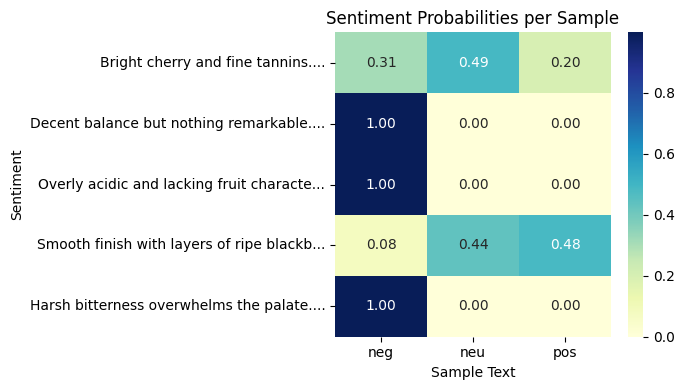

In [ ]:
plt.figure(figsize=(7,4))
sns.heatmap(
    df_pred[[c for c in df_pred.columns if c.startswith("Prob_")]],
    annot=True, fmt=".2f", cmap="YlGnBu",
    yticklabels=[t[:40]+"..." for t in df_pred["Text"]],
    xticklabels=[c.replace("Prob_", "") for c in df_pred.columns if c.startswith("Prob_")]
)
plt.title("Sentiment Probabilities per Sample")
plt.xlabel("Sample Text")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.show()


### 3.1c - Variety Country Predictor

In [52]:
# Initialize variables for the predictor
# adjust as needed; rest → OTHER
TOPK_VARIETIES = 40
MIN_PER_CLASS  = 2          # minimal for stratify to work
OTHER_TOKEN    = "OTHER"

In [53]:
# Initialize base model
BASE_MODEL = "distilbert-base-uncased"

**Variety model**

In [54]:
# Variety label list (top-K + OTHER)
vc_var = data_wine['variety'].astype(str).value_counts()
variety_labels = vc_var.index[:TOPK_VARIETIES].tolist() + [OTHER_TOKEN]

In [55]:
# --- Variety dataset
df_var = data_wine[['description','variety']].dropna().copy()
df_var['variety'] = df_var['variety'].astype(str)
df_var.loc[~df_var['variety'].isin(variety_labels), 'variety'] = OTHER_TOKEN

var2id = {l:i for i,l in enumerate(variety_labels)}
df_var['label_id'] = df_var['variety'].map(var2id)

tr_v, va_v = train_test_split(
    df_var, test_size=0.15, random_state=42, stratify=df_var['label_id']
)

tok_var = AutoTokenizer.from_pretrained(BASE_MODEL)
train_ds_var = SingleLabelTextDS(tr_v['description'].tolist(),
                                 tr_v['label_id'].tolist(),
                                 tok_var, max_len=MAX_LEN)
val_ds_var   = SingleLabelTextDS(va_v['description'].tolist(),
                                 va_v['label_id'].tolist(),
                                 tok_var, max_len=MAX_LEN)

In [56]:
trainer_var = train_one_classifier(
    train_ds=train_ds_var,
    val_ds=val_ds_var,
    label_list=variety_labels,
    out_dir=f"{MODELS_DIR}/variety_distilbert",
    base_model=BASE_MODEL,
    epochs=3, batch_size=16, lr=2e-5,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.063700,0.978386,0.701332,0.732759,0.605280,0.628960
2,0.942400,0.846181,0.740453,0.750527,0.663628,0.681720
3,0.694200,0.810898,0.756982,0.746974,0.684455,0.699208


In [57]:
# 1. Load trained model bundle
var_bundle = load_classifier(f"{MODELS_DIR}/variety_distilbert")

# var_bundle contains:
# {
#   "model": AutoModelForSequenceClassification,
#   "tokenizer": AutoTokenizer,
#   "labels": [...],   # the label list
#   "device": "cuda" or "cpu"
# }

In [58]:
# 2. Predict on new samples
samples = [
    "Ripe blackberry, plum and vanilla with firm tannins.",
    "Crisp apple and lemon zest; bright acidity."
]

preds_var = predict_cls(samples, var_bundle)

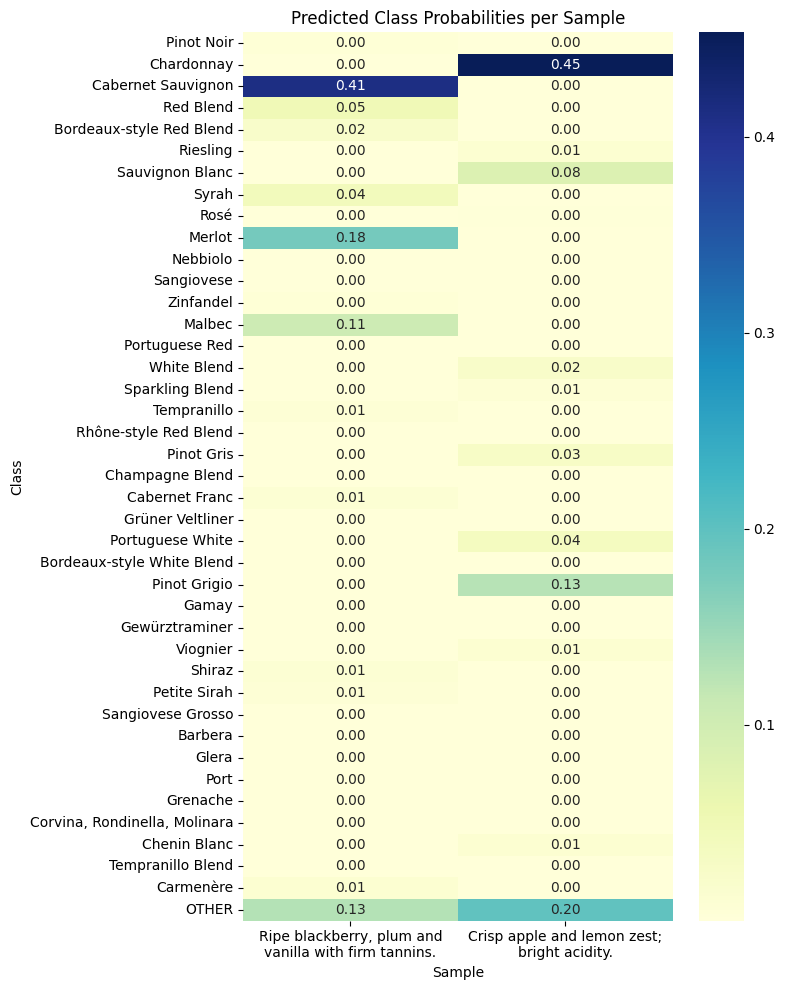

In [59]:
# 3. View results - probability matrix
df_var = pd.DataFrame([
    {lbl: p["probs"][lbl] for lbl in p["probs"].keys()}
    for p in preds_var
], index=[ "\n".join(textwrap.wrap(s, width=30)) for s in samples ])

plt.figure(figsize=(8, 10))
sns.heatmap(df_var.T, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Predicted Class Probabilities per Sample")
plt.xlabel("Sample")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

**Country model**

In [61]:
# Country label list (keep all; or set TOPK_COUNTRIES to cap)
country_labels = data_wine['country'].dropna().astype(str).value_counts(normalize_text).round(3)
display(country_labels)

,proportion
country,
US,0.419
France,0.170
Italy,0.150
Spain,0.051
Portugal,0.044
Chile,0.034
Argentina,0.029
Austria,0.026
Australia,0.018


> From the results above we can see that `US` country is heavily skewed. We should implement a sampling technique to improve generalization

In [62]:
from sklearn.utils import resample

MIN_SAMPLES_US = 18_000      # cap for US
MIN_PER_CLASS  = 2        # needed for stratified split

# --- Country dataset
df_cty = data_wine[['description','country']].dropna().copy()
df_cty['country'] = df_cty['country'].astype(str)

# 1) Downsample US to MIN_SAMPLES_US (keep all others)
df_us   = df_cty[df_cty['country'] == 'US']
df_rest = df_cty[df_cty['country'] != 'US']
if len(df_us) > MIN_SAMPLES_US:
    df_us = resample(df_us, replace=False, n_samples=MIN_SAMPLES_US, random_state=42)

df_cty_bal = pd.concat([df_rest, df_us], ignore_index=True)

# 2) Ensure every class has at least MIN_PER_CLASS (required by stratify)
vc = df_cty_bal['country'].value_counts()
keep_labels = vc[vc >= MIN_PER_CLASS].index
df_cty_bal = df_cty_bal[df_cty_bal['country'].isin(keep_labels)]


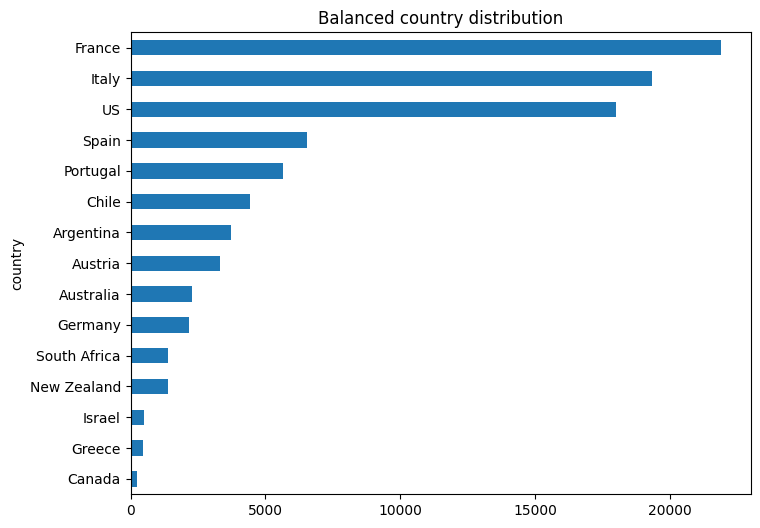

In [63]:
df_cty_bal['country'].value_counts().sort_values(ascending=True).tail(15).plot(kind='barh', figsize=(8,6))

plt.title("Balanced country distribution")
plt.show()

In [64]:
# 3) Encode labels
cty_labels = df_cty_bal['country'].value_counts().index.tolist()
cty2id = {l:i for i,l in enumerate(cty_labels)}
df_cty_bal['label_id'] = df_cty_bal['country'].map(cty2id)

# 4) Stratified split
tr_c, va_c = train_test_split(
    df_cty_bal, test_size=0.25, random_state=42, stratify=df_cty_bal['label_id']
)

# 5) Datasets
tok_cty = AutoTokenizer.from_pretrained(BASE_MODEL)
train_ds_cty = SingleLabelTextDS(tr_c['description'].tolist(),
                                 tr_c['label_id'].tolist(),
                                 tok_cty, max_len=MAX_LEN)
val_ds_cty   = SingleLabelTextDS(va_c['description'].tolist(),
                                 va_c['label_id'].tolist(),
                                 tok_cty, max_len=MAX_LEN)

In [ ]:
# # --- Country dataset
# df_cty = data_wine[['description','country']].dropna().copy()
# df_cty['country'] = df_cty['country'].astype(str)

# MIN_SAMPLES = 800    # cap for US

# vc = df_cty['country'].value_counts()
# keep = vc[vc >= MIN_PER_CLASS].index
# df_cty = df_cty[df_cty['country'].isin(keep)]

# cty_labels = df_cty['country'].value_counts().index.tolist()
# cty2id = {l:i for i,l in enumerate(cty_labels)}
# df_cty['label_id'] = df_cty['country'].map(cty2id)

# tr_c, va_c = train_test_split(
#     df_cty, test_size=0.25, random_state=42, stratify=df_cty['label_id']
# )

# tok_cty = AutoTokenizer.from_pretrained(BASE_MODEL)
# train_ds_cty = SingleLabelTextDS(tr_c['description'].tolist(),
#                                  tr_c['label_id'].tolist(),
#                                  tok_cty, max_len=MAX_LEN)
# val_ds_cty   = SingleLabelTextDS(va_c['description'].tolist(),
#                                  va_c['label_id'].tolist(),
#                                  tok_cty, max_len=MAX_LEN)

In [65]:
trainer_cty = train_one_classifier(
    train_ds=train_ds_cty,
    val_ds=val_ds_cty,
    label_list=cty_labels,
    out_dir=f"{MODELS_DIR}/country_distilbert",
    base_model=BASE_MODEL,
    epochs=3, batch_size=16, lr=2e-5
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.198100,0.218879,0.944054,0.402618,0.391234,0.382874
2,0.150900,0.140346,0.967580,0.582381,0.536670,0.536792
3,0.089900,0.132700,0.973020,0.638498,0.581492,0.586903


In [66]:
# 1. Load trained model bundle
cty_bundle = load_classifier(f"{MODELS_DIR}/country_distilbert")

# var_bundle contains:
# {
#   "model": AutoModelForSequenceClassification,
#   "tokenizer": AutoTokenizer,
#   "labels": [...],   # the label list
#   "device": "cuda" or "cpu"
# }

In [67]:
# 2. Predict on new samples
samples = [
    "Ripe blackberry, plum and vanilla with firm tannins.",                   # full-bodied red
    "Crisp apple and lemon zest; bright acidity.",                            # refreshing white
    "Rich cherry and oak notes with a long smooth finish.",                   # aged red
    "Light floral aroma, hints of peach and honey.",                          # aromatic white
    "Earthy and spicy, with subtle tobacco and black pepper nuances."         # complex red
]

preds_cty = predict_cls(samples, cty_bundle)

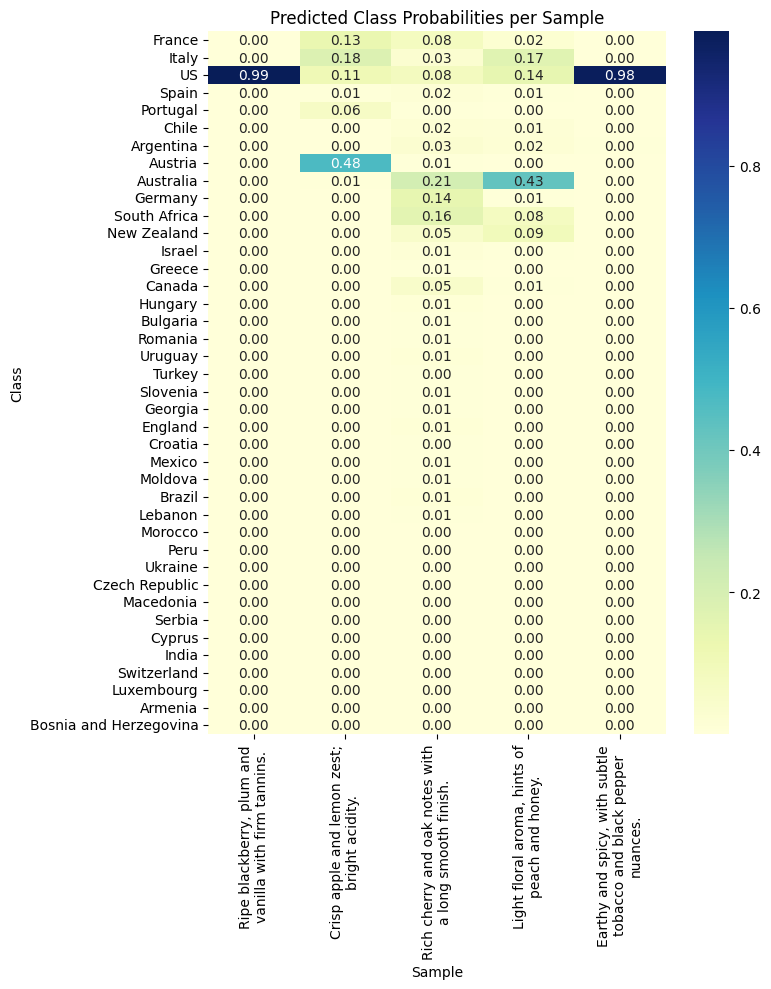

In [68]:
# 3. View results - probability matrix
df_cty = pd.DataFrame([
    {lbl: p["probs"][lbl] for lbl in p["probs"].keys()}
    for p in preds_cty
], index=[ "\n".join(textwrap.wrap(s, width=30)) for s in samples ])

plt.figure(figsize=(8, 10))
sns.heatmap(df_cty.T, annot=True, cmap="YlGnBu", fmt=".2f")

plt.title("Predicted Class Probabilities per Sample")
plt.xlabel("Sample")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

## 3.2 Embeddings & Vector Index (Retrieval Layer)

## 3.3 Query Processing & Candidate Retrieval